# Part3. 모델 불러오기 및 유사도 검색

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 모델 및 이미지 array 불러오기

In [2]:
from keras.models import load_model

autoencoder = load_model('/content/drive/MyDrive/project/autoencoder_final.h5')

In [3]:
import numpy as np

image_dir = '/content/drive/MyDrive/project/image_array.npy'
Ent_image = np.load(image_dir)

Ent_image.shape

(3329, 32, 32, 3)

### 2. 모델의 잠재 벡터

In [37]:
from keras.models import Model

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)
latent_vector = encoder.predict(Ent_image)

105/105 [==============================] - 2s 15ms/step


In [39]:
latent_vector.shape

(3329, 2, 2, 32)

### 3. 영상 다운로드

RAM사용량 제한이 있는 관계로, 영상에서 캡쳐한 8개의 이미지들로 유사도 계산을 진행할 것입니다.

In [9]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

def preprocess_images(folder_path, grayscale=True):

    # 폴더 내 파일 이름들 가져오기
    file_names = os.listdir(folder_path)

    # 이미지 처리 결과를 저장할 리스트
    processed_images = []

    # 파일들에 대해 반복적으로 처리
    for file_name in file_names:

        if file_name == ".ipynb_checkpoints":
              continue

        # 이미지 파일 경로
        image_path = os.path.join(folder_path, file_name)

        # 이미지 열기
        with Image.open(image_path) as image:
            # 이미지 크기 조정
            resized_image = image.resize((32, 32))

            # 컬러 이미지를 흑백으로 변환
            if grayscale:
                resized_image = resized_image.convert("L")

            # 이미지 전처리
            normalized_image = np.array(resized_image) / 255.0

            # 차원 조정
            input_image = np.expand_dims(normalized_image, axis=0)

            # 처리된 이미지를 결과 리스트에 추가
            processed_images.append(input_image)

    # 결과 리스트를 NumPy 배열로 변환
    processed_images = np.array(processed_images)

    return processed_images

In [24]:
frames_dir = '/content/drive/MyDrive/frames'
frame_images = preprocess_images(frames_dir, grayscale=False)

In [25]:
frame_images.shape

(8, 1, 32, 32, 4)

In [29]:
frame_images = frame_images.reshape((8, 32, 32, 4, 1))

In [31]:
frame_images = frame_images[:, :, :, :3, 0]

In [33]:
frame_images.shape

(8, 32, 32, 3)

In [50]:
frame_latent_vector = encoder.predict(frame_images)

1/1 [==============================] - 0s 52ms/step


### 거리 계산

In [51]:
encoder_flat = latent_vector.reshape((latent_vector.shape[0], -1))
frames_flat = frame_latent_vector.reshape((frame_latent_vector.shape[0], -1))

# Calculate the Euclidean distance between each pair of images
distances = np.linalg.norm(encoder_flat[:, np.newaxis] - frames_flat, axis=2)

# Print the shape of the distances array
print(distances.shape)

(3329, 8)


In [55]:
min_distance_indices = np.where(distances == np.min(distances))

In [56]:
min_distance_indices

(array([432]), array([3]))

학습된 모델의 432인덱스와, 프레임의 3인덱스가 가장 유사한 이미지라고 하여 시각화 해봅니다.

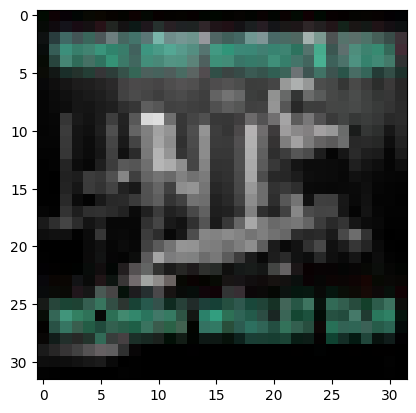

In [60]:
import matplotlib.pyplot as plt
plt.imshow(Ent_image[432])

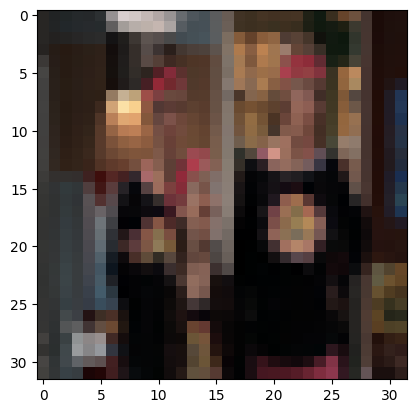

In [59]:
plt.imshow(frame_images[3])

## 한계점 및 추후 발전 방향

### 보완할 점
1. 학습을 계속 진행하여 Loss을 감소시킨다. (20000 Epoch당 0.01정도 줄었음)​
2. 테스트 데이터를 확보한다. (RAM, 저작권 문제 등 해결)​
3. resizing을 영상 비율에 맞게 다시 한다.

### 프로젝트 발전 방향
1. 더욱 세분화 된 카테고리 학습 및​ 사용자 데이터 수집
2. 영상 내용 관련한​ 관련 이미지 학습(레이블링 요)
3. 자연어 처리를 이용한​ 알맞은 타이틀 학습 & 타이틀 데이터​ 확보
4. 실제 서비스 시 효율성을 위해​ 상황에 맞는 기술 적절히 사용​